# Purpose of this simulation

we wanted to check that with full matrix works with lasso regression?

In [36]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import aopy
import sklearn
from weights import *
from weights_linear_regression import calc_R2_with_sim_C

# so that we write in latex
from matplotlib import rc

rc('font', **{'family':'serif','serif':['Palatino']})
rc('text', usetex=False)

import numpy as np
np.set_printoptions(precision=5, suppress=True)
sns.set_context('paper')

# ideas

In [13]:
data_dump_folder = \
        '/home/aolab/sijia/data/figure3_lasso/'

ROUND_DECIMALS = 3


random_seed =2
n_neurons = 128

# clda setup 
rho = 0.5
batchlen = 100
feature_selection_method = "joint_convex"
encoder_change_mode = "shuffle_rows"
# encoder_change_mode = "change_to_zeros"

# noises = np.arange(9)
# noises = np.exp2(noises)
noises = [32]
noise = 32

# we set up the neural populations
mean_first_peak = 50
mean_second_peak = 100
std_of_peaks = 3

# feature_selection_method 
feature_selection_method = "full"
exp_conds = []

# uncomment out this to compare to the full feature selection method
# exp_conds_wo = [f'{feature_selection_method}_{1.0}_{random_seed}_noise_{noise}_{n_neurons}_{mean_second_peak}_{std_of_peaks}_clda_rho_{rho}_batchlen_{batchlen}_{encoder_change_mode}' ]
# exp_conds += exp_conds_wo




#smoothness_array =  np.arange(0.025, 0.15, 0.025)
smoothness_array = [0.05]
num_lags_array = [3]
num_of_features = 32 # specify how many features we want to use, or None


##### lasso
lasso_alphas = [10]
lasso_thresholds = [ 0, 1]
more_exp_conds = []
for lasso_alpha in lasso_alphas:
    for lasso_threshold in lasso_thresholds:
        more_exp_conds.append(f'lasso_{1.0}_{random_seed}_noise_{noise}_{n_neurons}_{mean_second_peak}_{std_of_peaks}_clda_rho_{rho}_batchlen_{batchlen}_lasso_alpha_{lasso_alpha}_lasso_threshold_{lasso_threshold}_{encoder_change_mode}')
exp_conds += more_exp_conds
        
##### last one is with the full feature selection
more_exp_conds = []
updater_type = "smooth_batch_with_full_feature"
for lasso_alpha in lasso_alphas:
    for lasso_threshold in lasso_thresholds:
        more_exp_conds.append(f'lasso_{1.0}_{random_seed}_noise_{noise}_{n_neurons}_{mean_second_peak}_{std_of_peaks}_clda_rho_{rho}_batchlen_{batchlen}_lasso_alpha_{lasso_alpha}_lasso_threshold_{lasso_threshold}_{encoder_change_mode}')

# add smooth batch with full batch
UPDATER_TYPE = "smooth_batch_with_full_feature"
if  UPDATER_TYPE != 'smooth_batch':
    for i, exp_cond in enumerate(more_exp_conds):
        more_exp_conds[i] = exp_cond + f'_{UPDATER_TYPE}'
        
exp_conds += more_exp_conds

# feature_selection_schemes = ['lasso threshold 0','lasso threshold 1', 'lasso threshold 2', 'lasso threshold 2.5',
#                              'lasso threshold 0 w/ full matrix','lasso w/ full matrix threshold 1', 'lasso w/ full matrix threshold 2', 'lasso w/ full matrix threshold 2.5']

feature_selection_schemes = ['lasso threshold 32',
                             'lasso threshold 64', 
                             'lasso w/ full matrix threshold 32 ',
                             'lasso w/ full matrix threshold 64']


print("the folder at which data is located:")
print(data_dump_folder)
for m,e in zip(feature_selection_schemes, exp_conds):print(m, ':', e)

the folder at which data is located:
/home/aolab/sijia/data/figure3_lasso/
lasso threshold 32 : lasso_1.0_2_noise_32_128_100_3_clda_rho_0.5_batchlen_100_lasso_alpha_10_lasso_threshold_0_shuffle_rows
lasso threshold 64 : lasso_1.0_2_noise_32_128_100_3_clda_rho_0.5_batchlen_100_lasso_alpha_10_lasso_threshold_1_shuffle_rows
lasso w/ full matrix threshold 32  : lasso_1.0_2_noise_32_128_100_3_clda_rho_0.5_batchlen_100_lasso_alpha_10_lasso_threshold_0_shuffle_rows_smooth_batch_with_full_feature
lasso w/ full matrix threshold 64 : lasso_1.0_2_noise_32_128_100_3_clda_rho_0.5_batchlen_100_lasso_alpha_10_lasso_threshold_1_shuffle_rows_smooth_batch_with_full_feature


In [14]:
from afs_files import load_feature_selection_files, load_and_convert_clda_pickle_files
(exp_data_all, exp_metadata_all) = load_feature_selection_files(data_dump_folder, exp_conds)
clda_data_all = load_and_convert_clda_pickle_files(data_dump_folder, exp_conds)
print(f'we collected {len(exp_data_all)} number of experiments')

/home/aolab/sijia/analyze/aopy/preproc/bmi3d.py:382: UserWarning: Warning: no sync clock connected! This will usually result in problems.
  warnings.warn("Warning: no sync clock connected! This will usually result in problems.")
/home/aolab/sijia/analyze/aopy/preproc/bmi3d.py:449: UserWarning: No sync events present, using bmi3d events instead
  warnings.warn("No sync events present, using bmi3d events instead")


we collected 4 number of experiments


# Check feature selection strategies

## Plot selected features across feature selection methods

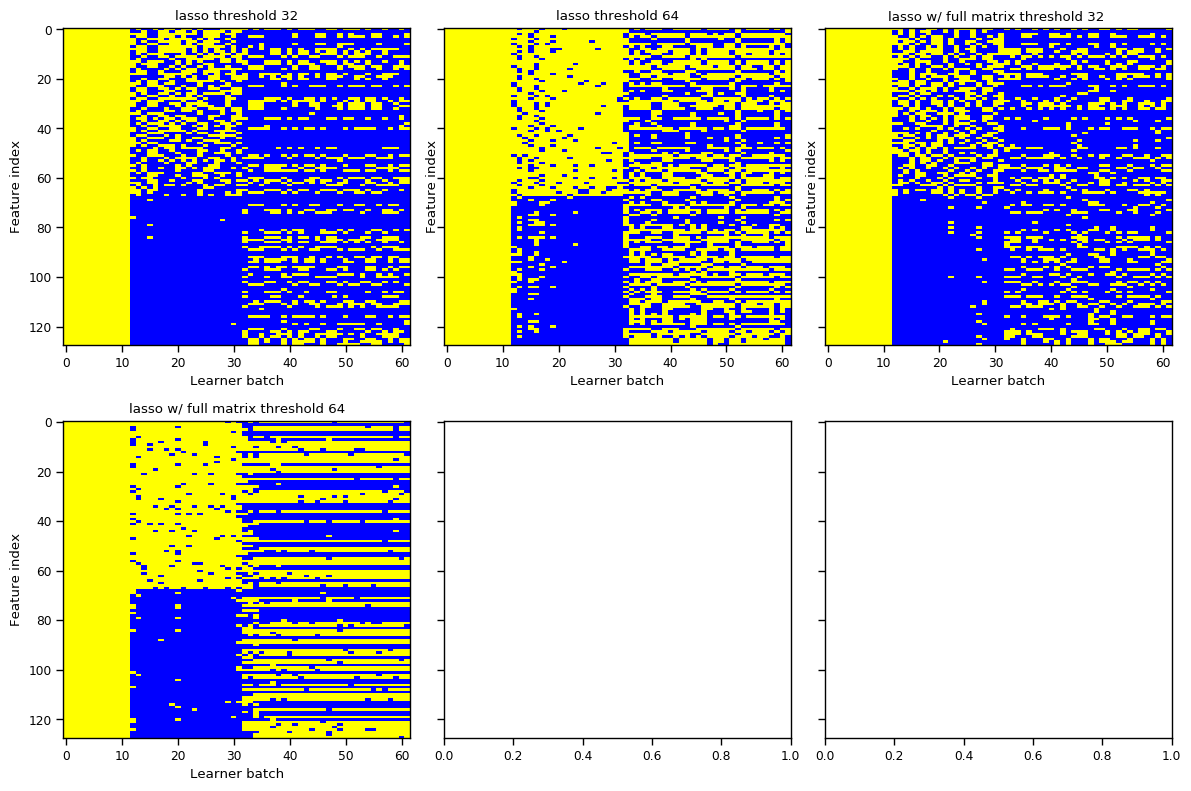

In [15]:
import importlib 
from afs_plotting import plot_feature_selection

if len(exp_data_all) ==  1:
    plot_feature_selection(exp_data_all[0]['feature_selection']['feat_set'])
else:
    
    num_columns = len(exp_data_all)

    fig_feat_activity, ax_feat_activity = plt.subplots(2, 3, 
                                                    sharey = True,
                                                    figsize = (12, 8))

    for i, (e, a) in enumerate(zip(exp_data_all,  ax_feat_activity.flatten())):
        plot_feature_selection(e['feature_selection']['feat_set'], ax = a)
        
        a.set_title(feature_selection_schemes[i])

fig_feat_activity.tight_layout()



In [16]:
# next question I ask,  how many features are being selected, anyway? 
num_features_exp_by_batch = []

selected_feature_batches = [exp_data_all[i]['feature_selection']['feat_set'] for i in range(len(exp_data_all))]

for i,e in enumerate(exp_data_all):

    active_set = e['feature_selection']['feat_set']

    num_features_over_batch = np.sum(active_set, axis = 1)
    num_features_exp_by_batch.append(num_features_over_batch.copy())

num_features_exp_by_batch = np.array(num_features_exp_by_batch)
selected_feature_batches = np.array(selected_feature_batches)


In [17]:
print(selected_feature_batches.shape)

selected_features_conds_by_feature_batches = np.moveaxis(selected_feature_batches, 1, 2)


smoothness_conds_by_batch = \
calculate_feature_smoothness_multiple_conditions(selected_features_conds_by_feature_batches, 
                                                 mode = "incremental")

print(smoothness_conds_by_batch.shape)

(4, 62, 128)
(4, 61)


/home/aolab/miniconda3/envs/sijia-feature-analysis/lib/python3.8/site-packages/matplotlib/cbook/__init__.py:1402: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  ndim = x[:, None].ndim
/home/aolab/miniconda3/envs/sijia-feature-analysis/lib/python3.8/site-packages/matplotlib/axes/_base.py:276: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x = x[:, np.newaxis]
/home/aolab/miniconda3/envs/sijia-feature-analysis/lib/python3.8/site-packages/matplotlib/axes/_base.py:278: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  y = y[:, np.newaxis]
/home/aolab/miniconda3/envs/sijia-feature-analysis/

(4, 61)

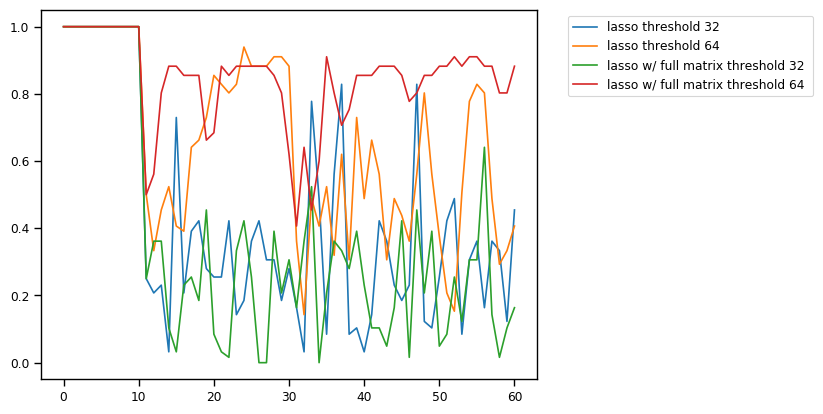

In [18]:
#sns.set_palette("Blues")

ax  = sns.lineplot(data = smoothness_conds_by_batch.T, dashes=False)
# ax.set_xticklabels(sparsity_array)
ax.set_title("")

# put legend outside of the plot

ax.legend(feature_selection_schemes, bbox_to_anchor=(1.05, 1), loc=2)
smoothness_conds_by_batch.shape

/home/aolab/miniconda3/envs/sijia-feature-analysis/lib/python3.8/site-packages/matplotlib/cbook/__init__.py:1402: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  ndim = x[:, None].ndim
/home/aolab/miniconda3/envs/sijia-feature-analysis/lib/python3.8/site-packages/matplotlib/axes/_base.py:276: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x = x[:, np.newaxis]
/home/aolab/miniconda3/envs/sijia-feature-analysis/lib/python3.8/site-packages/matplotlib/axes/_base.py:278: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  y = y[:, np.newaxis]
/home/aolab/miniconda3/envs/sijia-feature-analysis/

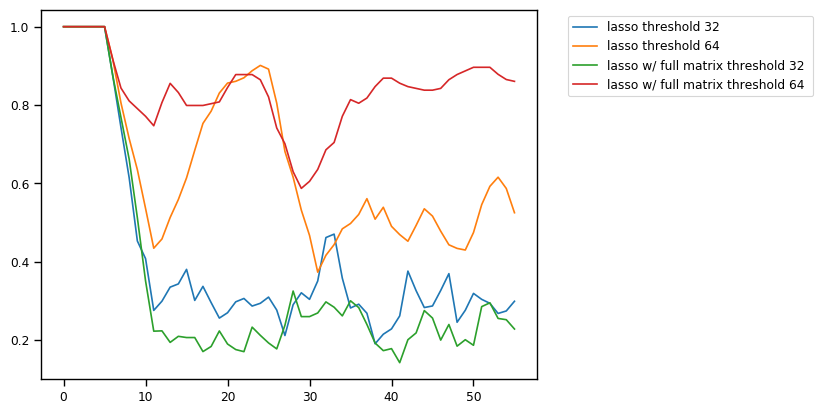

In [19]:

# Assuming smoothness_conds_by_batch is a numpy array with shape (n_batches, n_features)
window_size = 6
weights = np.ones(window_size) / window_size
smoothness_conds_by_batch_ma = np.apply_along_axis(lambda x: np.convolve(x, weights, mode='valid'), 
                                                   axis=1,
                                                   arr=smoothness_conds_by_batch)

ax  = sns.lineplot(data = smoothness_conds_by_batch_ma.T, dashes=False)
# ax.set_xticklabels(sparsity_array)
ax.set_title("")

# put legend outside of the plot

ax.legend(feature_selection_schemes, bbox_to_anchor=(1.05, 1), loc=2)

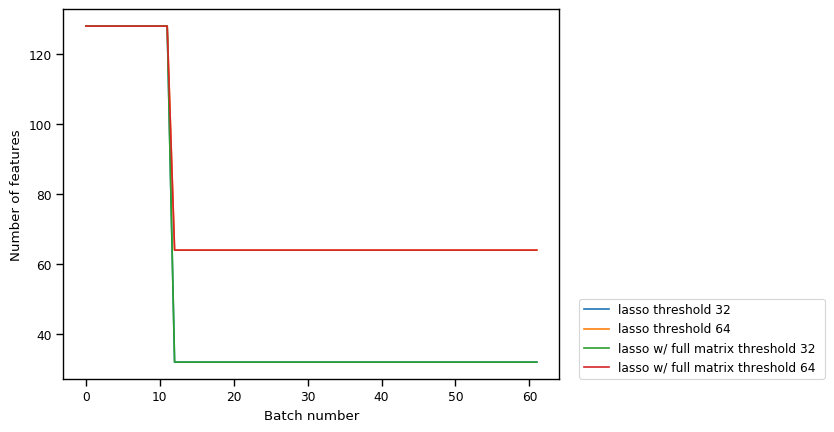

In [20]:
fig_num_features, ax_num_features = plt.subplots()

ax_num_features.plot(num_features_exp_by_batch.T)

ax_num_features.set_xlabel('Batch number')
ax_num_features.set_ylabel('Number of features')

ax_num_features.legend(feature_selection_schemes, loc=(1.04,0))

## calculate the relevance


In [21]:
from sklearn.metrics import r2_score

def calc_R2_with_sim_C( spike_counts_batch,intended_velocities, C_mat, active_set, 
                       remove_first_and_last_Batch = True, 
                       c_mat_remove_first_batch = True, 
                       select_only_vel_states = True,
                       select_features_with_active_set = False,
                       debug = True):
    
    
        # then we iterate through the batch sort of thing.
    NUM_LEARNER_BATCHES = intended_velocities.shape[0]
    
    if debug:
        print("intended_velocities", intended_velocities.shape)
        print("spike_counts_batch", len(spike_counts_batch))
        print("C_mat", C_mat.shape)
        print("active_set", active_set.shape)
    
    if remove_first_and_last_Batch:
        active_set = active_set[1:-1, :]
    if c_mat_remove_first_batch:
        C_mat = C_mat[1:, :, : ]
        
    if select_only_vel_states:
        C_mat = C_mat[:,:,(X_VEL_STATE, Y_VEL_STATE,CONST_STATE)]
        
    
    if debug:
        print("intended_velocities", intended_velocities.shape)
        print("spike_counts_batch", len(spike_counts_batch))
        print("C_mat", C_mat.shape)
        print("active_set", active_set.shape)
        

    
    R_2_over_batch = []
    
    for i in range(NUM_LEARNER_BATCHES):
        
        batch_vel =  intended_velocities[i,:,:]
        
        # check if we get the data from the list or the np.ndarray
        if type(spike_counts_batch) == list:
            batch_spike_counts = spike_counts_batch[i]
        else:
            batch_spike_counts = spike_counts_batch[i,:,:]
        
        #  we can only compare to what's being used in the calculation
        if select_features_with_active_set:
            if debug: print(batch_spike_counts.shape)
            batch_spike_counts = batch_spike_counts[active_set[i,:],:].T
        else:
            batch_spike_counts = batch_spike_counts[: ,:].T
        
        batch_c_mat = C_mat[i,:,:]
        
        selected_c_mat = batch_c_mat[active_set[i,:],:]
        

        estimated_spike_counts = selected_c_mat @ batch_vel
        
        score = r2_score(batch_spike_counts, estimated_spike_counts.T)
        
        R_2_over_batch.append(score)
        
    return R_2_over_batch

In [26]:

R_2_over_batches_all_exp = []


X_VEL_STATE = 3
Y_VEL_STATE = 5
CONST_STATE = 6

for exp_index in range(len(exp_data_all)):
    # intended_kin = exp_data_all[exp_index]['bmi3d_clda']['intended_kin']
    # spike_counts_batch = exp_data_all[exp_index]['bmi3d_clda']['spike_counts_batch']
    
    try:
        intended_kin = clda_data_all[exp_index]['intended_kin']
        spike_counts_batch = clda_data_all[exp_index]['spike_counts_batch']

        intended_kin = np.array(intended_kin)
        print(intended_kin.shape)

        intended_velocities = intended_kin[:, [X_VEL_STATE, Y_VEL_STATE, CONST_STATE],:]
        # # get C_mat
        feature_selection_data = exp_data_all[exp_index]['feature_selection']
        C_mat = feature_selection_data["C_mat"]
        feat_set = feature_selection_data["feat_set"]

        # # calculate R_2 over batches
        R_2_over_batches = calc_R2_with_sim_C(spike_counts_batch, 
                                            intended_velocities,
                                            C_mat, feat_set, debug = False)
        
        # #save  the results
        R_2_over_batches_all_exp.append(R_2_over_batches)
        
        
    except Exception as e:
        print(f"KeyError: {e}not found in data.")
    
    # #save  the results
    # R_2_over_batches_all_exp.append(R_2_over_batches)
    
    print(exp_index)
    
R_2_over_batches_all_exp = np.array(R_2_over_batches_all_exp)
R_2_over_batches_all_exp_gap = R_2_over_batches_all_exp.T

(60, 7, 100)
0
(60, 7, 100)
1
(60, 7, 100)
2
(60, 7, 100)
3


In [36]:
# apply moving average to the first axis
window_size = 6
weights = np.ones(window_size) / window_size
R_2_over_batches_all_exp_gap_ma = np.apply_along_axis(lambda x: np.convolve(x, weights, mode='valid'), 
                                                   axis=0,
                                                   arr=R_2_over_batches_all_exp_gap)

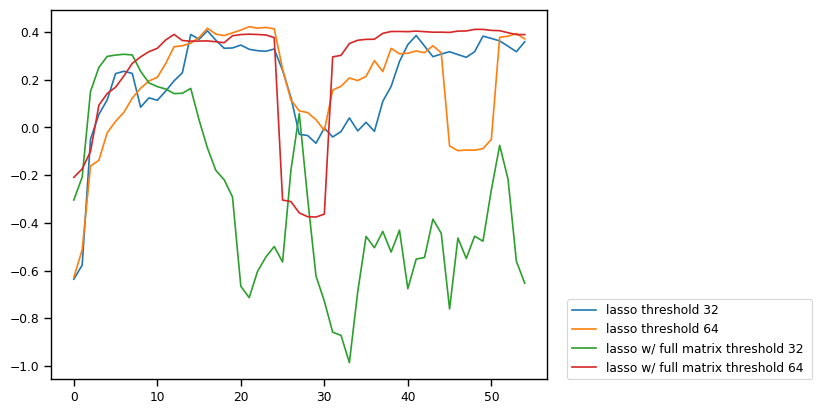

In [37]:
plt.plot(R_2_over_batches_all_exp_gap_ma)
plt.legend(feature_selection_schemes, loc=(1.04,0))



# Behaviour comparision

## count how many rewards

In [39]:
fps = 60

reward_rate_all = list()
window_time_stamps_all = list()
NUM_EXP = len(exp_data_all)

total_rewards_all = list()

for i in range(NUM_EXP):

    time_stamps = exp_data_all[i]['events']['time'] / fps
    events = exp_data_all[i]['events']['event']
    
    
    num_rewards = np.count_nonzero(events == b'REWARD')

    (reward_rate, window_time_stamps) = aopy.analysis.calc_running_event_rate(b'REWARD', events, time_stamps, 
                                                                window_size= 120,
                                                                 window_step= 30)
    reward_rate_all.append(reward_rate)
    window_time_stamps_all.append(window_time_stamps)
    total_rewards_all.append(num_rewards)


window_stamps_all = np.array(window_time_stamps_all)
reward_rate_all = np.array(reward_rate_all) 
reward_rate_all = reward_rate_all.reshape((NUM_EXP,-1))
window_stamps_all = window_stamps_all.reshape((NUM_EXP,-1))

total_rewards_all = np.array(total_rewards_all)

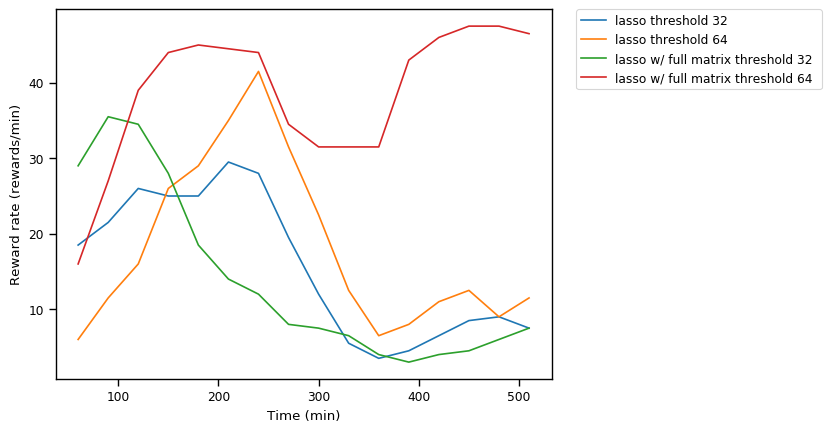

In [40]:
colors = ['blue', 'orange', 'red']

plt.plot(window_time_stamps, reward_rate_all.T)
plt.xlabel('Time (min)')
plt.ylabel(r'Reward rate (rewards/min)')
# put the legend outside of the figure
plt.legend(feature_selection_schemes, bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)


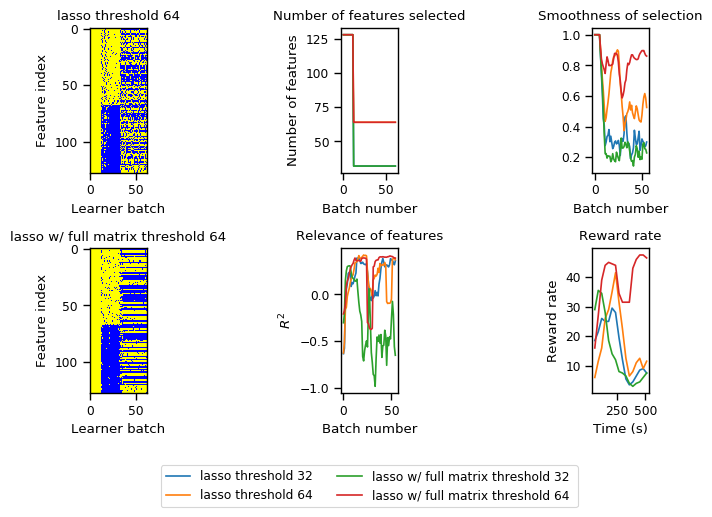

In [43]:
# let's make a summary plot
summary_figure, summary_axes = plt.subplots(2, 3, figsize = (6.5, 5.5))

# plot the feature selection results
plot_feature_selection(exp_data_all[1]['feature_selection']['feat_set'], ax = summary_axes[0,0])
plot_feature_selection(exp_data_all[3]['feature_selection']['feat_set'], ax = summary_axes[1,0])
summary_axes[0,0].set_title(feature_selection_schemes[1])
summary_axes[1,0].set_title(feature_selection_schemes[3])


# number of features selected
summary_axes[0,1].plot(num_features_exp_by_batch.T)
summary_axes[0,1].set_xlabel('Batch number')
summary_axes[0,1].set_ylabel('Number of features')
summary_axes[0,1].set_title('Number of features selected')
# plot the relevance of the features

summary_axes[1,1].plot(R_2_over_batches_all_exp_gap_ma)
summary_axes[1,1].set_xlabel('Batch number')
summary_axes[1,1].set_ylabel(r'$R^2$')
summary_axes[1,1].set_title('Relevance of features')

# put the legend below the plot
summary_axes[1,1].legend(feature_selection_schemes, bbox_to_anchor=(0.5, -0.5), loc=9, borderaxespad=0., ncol = 2)


# plot the smoothness of the features
summary_axes[0,2].plot(smoothness_conds_by_batch_ma.T)
summary_axes[0,2].set_xlabel('Batch number')
summary_axes[0,2].set_title('Smoothness of selection')

# plot the reward rate
summary_axes[1,2].plot(window_time_stamps, reward_rate_all.T)
summary_axes[1,2].set_ylabel('Reward rate')
summary_axes[1,2].set_xlabel('Time (s)')
summary_axes[1,2].set_title('Reward rate')



# plot the reward rate
summary_figure.tight_layout()

In [157]:
summary_figure.savefig('encoder_change_summary_figure.png', bbox_inches='tight')